# Comparison of machine learning models in predicting student grades

### About Dataset
This dataset is a synthetic representation of student performance, designed to mimic real-world scenarios by considering key factors such as study habits, sleep patterns, socioeconomic background, and class attendance. Each row represents a hypothetical student, and the dataset includes both input features and the calculated target variable (grades).


### Key features
1. Study Hours - average daily hours spent studying
2. Sleep Hours - average daily hours spent sleeping.
3. Socioeconomic Score - a normalized score (0-1) indicating the student's socioeconomic background.
4. Attendance (%) - The percentage of classes attended by the student.
5. Grades (TARGET) - The final performance score of the student, derived from a combination of study hours, sleep hours, socioeconomic score, and attendance.

### Source: https://www.kaggle.com/datasets/stealthtechnologies/predict-student-performance-dataset/data

# Imports

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from keras.layers import Dropout
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

# Exploratory Data Analysis (EDA)

In [4]:
df = pd.read_csv("student_performance.csv")

In [5]:
df.head()

,Socioeconomic Score,Study Hours,Sleep Hours,Attendance (%),Grades
0,0.95822,3.4,8.2,53.0,47.0
1,0.85566,3.2,5.9,55.0,35.0
2,0.68025,3.2,9.3,41.0,32.0
3,0.25936,3.2,8.2,47.0,34.0
4,0.60447,3.8,10.0,75.0,33.0


In [6]:
print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")

Number of rows: 1388
Number of columns: 5


In [7]:
df.columns

Index(['Socioeconomic Score', 'Study Hours', 'Sleep Hours', 'Attendance (%)',
       'Grades'],
      dtype='object')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1388 entries, 0 to 1387
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Socioeconomic Score  1388 non-null   float64
 1   Study Hours          1388 non-null   float64
 2   Sleep Hours          1388 non-null   float64
 3   Attendance (%)       1388 non-null   float64
 4   Grades               1388 non-null   float64
dtypes: float64(5)
memory usage: 54.3 KB


In [9]:
df.describe()

,Socioeconomic Score,Study Hours,Sleep Hours,Attendance (%),Grades
count,1388.000000,1388.000000,1388.000000,1388.000000,1388.000000
mean,0.552274,4.560807,8.047262,58.536023,40.691643
std,0.261272,1.897581,1.370700,11.675287,9.467358
min,0.101280,0.800000,4.800000,40.000000,32.000000
25%,0.322118,3.475000,7.000000,49.000000,34.000000
50%,0.545945,3.900000,8.400000,57.000000,35.000000
75%,0.789610,5.900000,9.100000,66.000000,47.000000
max,0.999820,10.000000,10.000000,100.000000,91.000000


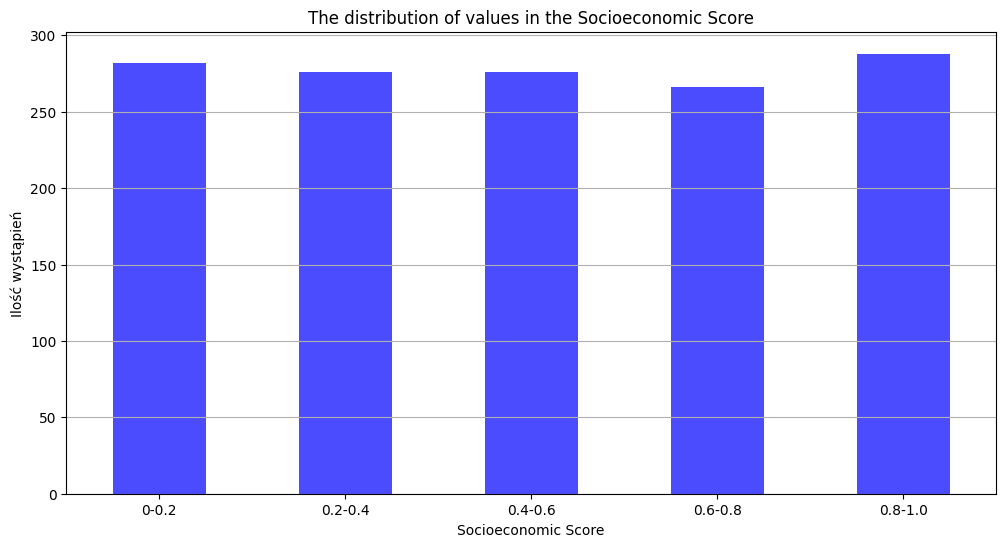

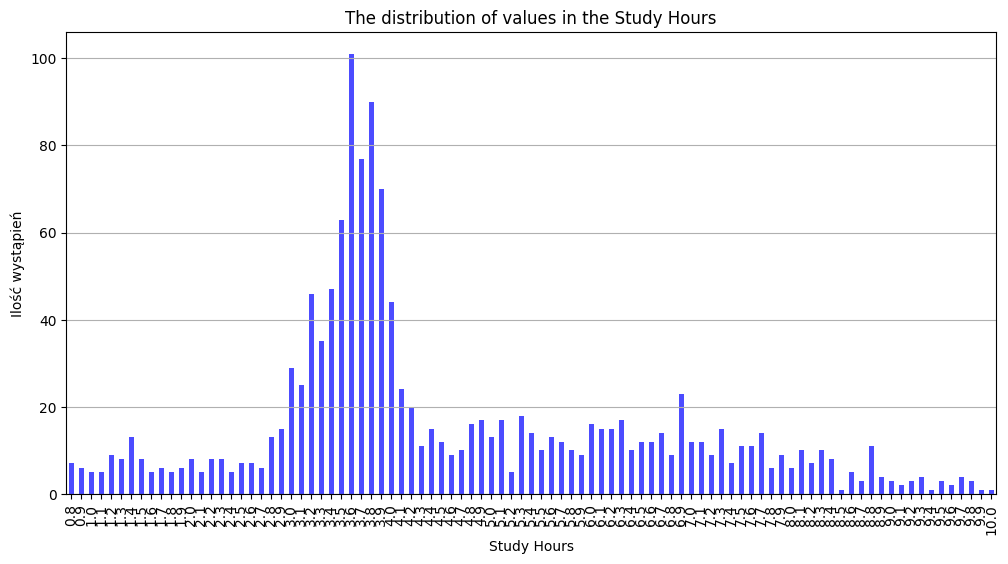

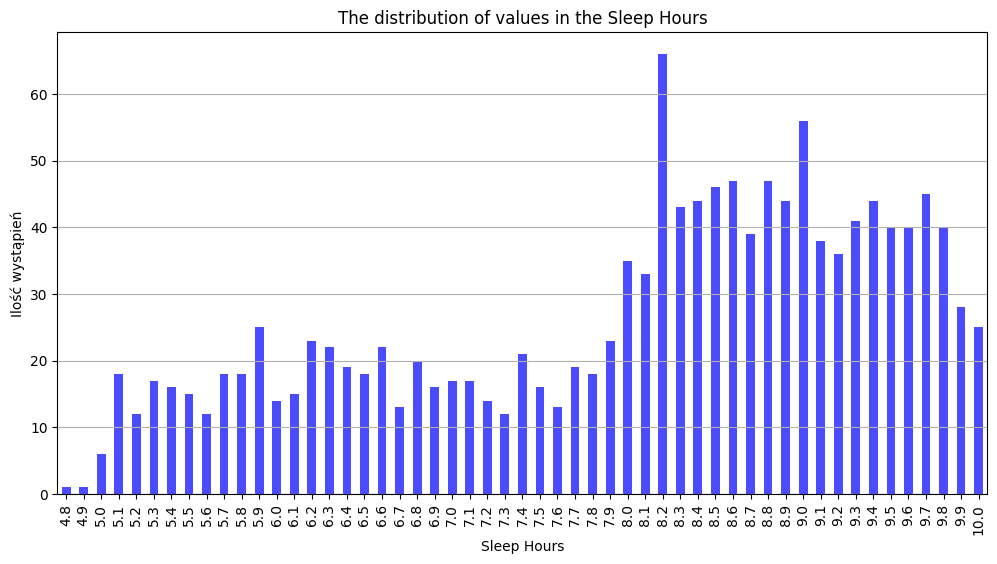

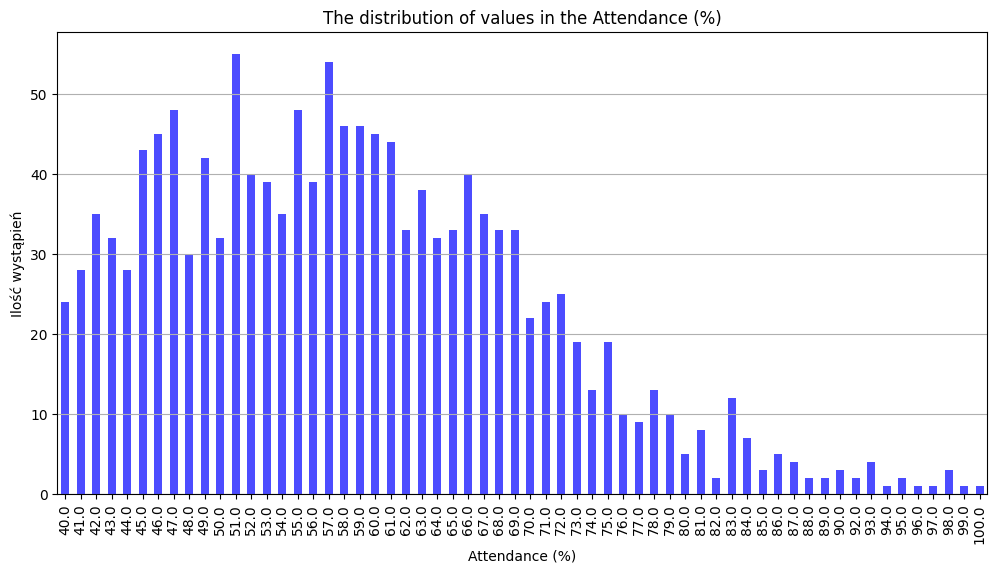

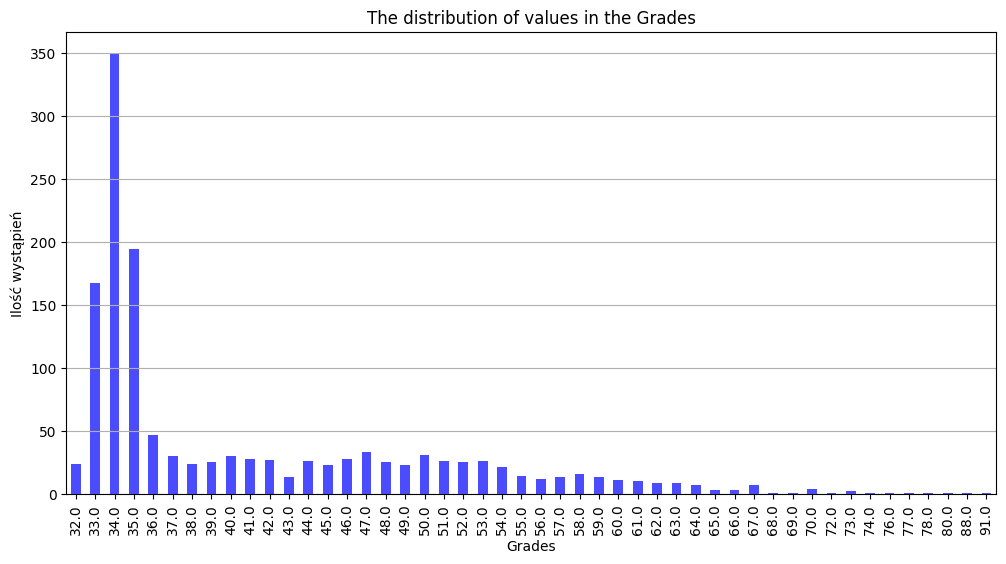

In [10]:
# The distribution of individual variables
for column in df.columns:
    if column == 'Socioeconomic Score':
        bins = pd.cut(df[column], bins=5, labels=["0-0.2", "0.2-0.4", "0.4-0.6", "0.6-0.8", "0.8-1.0"])
        grade_counts = bins.value_counts().sort_index()
    else:
        grade_counts = df[column].value_counts().sort_index()

    plt.figure(figsize=(12, 6))
    grade_counts.plot(kind='bar', color='blue', alpha=0.7)
    plt.xlabel(column)
    plt.ylabel('Ilość wystąpień')
    plt.title(f'The distribution of values in the {column}')
    if column == 'Socioeconomic Score':
        plt.xticks(rotation=0)
    plt.grid(axis='y')
    plt.show()

In [33]:
# Missing values check
missing_values = df.isna().sum()
print('Number of missing values:', '\n', missing_values)

Number of missing values: 
 Socioeconomic Score    0
Study Hours            0
Sleep Hours            0
Attendance (%)         0
Grades                 0
dtype: int64


In [34]:
# Duplicates check
duplicates = df.duplicated().sum()
print('Number of duplicates: ', duplicates)

Number of duplicates:  0


In [35]:
# Removing outliers
def outlier_check(row, colname):
    Q1 = row[colname].quantile(0.25)
    Q3 = row[colname].quantile(0.75)
    IQR = Q3 - Q1
    lower_b = Q1 - 1.5 * IQR
    upper_b = Q3 + 1.5 * IQR
    outlier = row.loc[(row[colname] < lower_b) | (row[colname] > upper_b)]
    return outlier

outliers = pd.DataFrame()

for col in df.select_dtypes(include=['number']).columns:
    outliers_in_col = outlier_check(df, col)
    outliers = pd.concat([outliers, outliers_in_col])

outliers.reset_index(drop=True, inplace=True)

In [36]:
print('Number of outliers: ', len(outliers))

Number of outliers:  50


In [37]:
# Shape of data frame after removing outliers
df = df[~df.index.isin(outliers.index)]
df.shape

(1338, 5)

In [38]:
# The correlation between the dependent variable and the independent variables.
df.corr()['Grades'].sort_values(ascending=False)

,Grades
Grades,1.000000
Study Hours,0.810220
Socioeconomic Score,0.336193
Attendance (%),0.329562
Sleep Hours,-0.127672


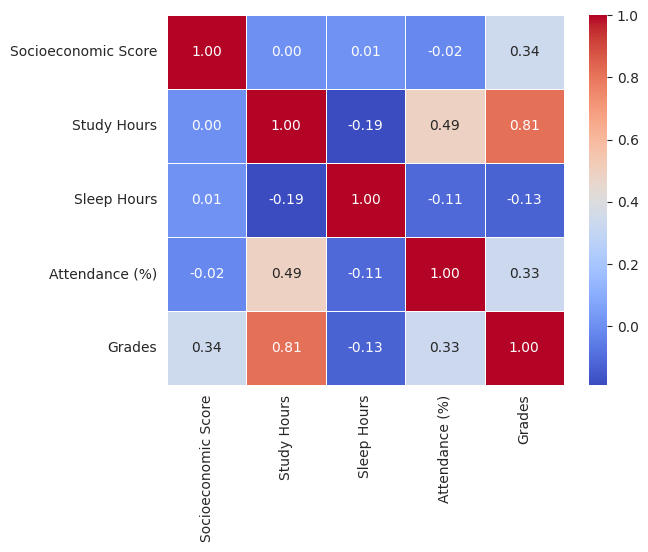

In [39]:
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm", linewidth=.5)
plt.show()

# Functions for visualization/model evaluation.

In [49]:
# Function for creating a plot of predicted vs. actual values for a single variable.
def real_vs_predicted_plot(model, y_test, y_pred):
    y_test = y_test.flatten() if len(y_test.shape) > 1 else y_test
    y_pred = y_pred.flatten() if len(y_pred.shape) > 1 else y_pred

    mse, r2 = metrics(y_test, y_pred)

    sns.set_style("whitegrid")

    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, color='blue', alpha=0.7, label='Predictions')
    plt.plot(
        [min(y_test), max(y_test)], [min(y_test), max(y_test)],
        color='red', linestyle='--', linewidth=2, label='Perfect line (y=x)'
    )


    plt.text(
        0.05, 0.95, f'$R^2 = {r2:.2f}$',
        transform=plt.gca().transAxes,
        fontsize=12, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
    )

    plt.xlabel('Real values', fontsize=12)
    plt.ylabel('Predicted values', fontsize=12)
    plt.title(f'Real vs Predicted ({model})', fontsize=14, fontweight='bold')

    plt.grid(visible=True, which='major', linestyle='--', alpha=0.6)
    plt.legend(fontsize=10)

    min_val = min(min(y_test), min(y_pred))
    max_val = max(max(y_test), max(y_pred))
    plt.xlim(min_val - 0.1 * abs(min_val), max_val + 0.1 * abs(max_val))
    plt.ylim(min_val - 0.1 * abs(min_val), max_val + 0.1 * abs(max_val))

    plt.tight_layout()
    plt.show()

# Function for retrieving metrics.
def metrics(y_test, y_pred):
  mse = mean_squared_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)
  return mse, r2

# Function to display metrics (R², MSE) for a single model.
def print_model_metrics(model_name, y_test, y_pred, model_params=None):
  mse, r2 = metrics(y_test, y_pred)
  print(f"Model: {model_name}")
  print(f"MSE: {mse:.3f}")
  print(f"R2: {r2:.3f}")
  if model_params != None:
    for param, value in model_params.items():
      print(f"{param}: {value}")

# Function that adds a model for comparison.
def add_to_comparision(model_name, mse, r2, y_pred, best_params={}):
  model_results.append({
      'Model': model_name,
      'Mean Squared Error': mse,
      'R-squared Score': r2,
      'y_pred' : y_pred,
      'best_params' : best_params
  })

# Function for generating a plot comparing training and validation losses over epochs.
def plot_loss(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()



# Function to display a performance comparison chart of models.
def plot_model_comparison(model_results_df):
    # Sorting models by R-squared Score.
    model_results_df.sort_values(by='R-squared Score', inplace=True)

    sns.set_style("whitegrid")

    fig, ax = plt.subplots(figsize=(12, 8))

    colors = sns.color_palette("Blues", len(model_results_df))

    bars = ax.barh(
        model_results_df['Model'],
        model_results_df['R-squared Score'],
        color=colors,
        alpha=0.9
    )

    for bar, score in zip(bars, model_results_df['R-squared Score']):
        ax.text(
            bar.get_width() + 0.01, bar.get_y() + bar.get_height() / 2,
            f"{score:.2f}",
            va='center', fontsize=10
        )

    ax.set_xlabel("R-squared Score", fontsize=14)
    ax.set_title("Model Performance Comparision", fontsize=18, fontweight='bold', pad=20)

    ax.set_yticklabels(model_results_df['Model'], fontsize=12)
    ax.tick_params(axis='y', which='both', length=0)

    plt.tight_layout()
    plt.show()


# Training ML Models

In [41]:
X = df.drop('Grades', axis=1)
y = df['Grades']

# splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [42]:
# List for storing model results.
model_results = []

# Parameters for different models.
ridge_params = {'model__alpha': [0.1, 1.0, 10.0, 100.0, 500.0, 1000.0]}

dt_params = {
    'model__max_depth': [3, 5, 7, 10, None],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 5],

}

svr_params = {
    'model__C': [0.1, 1, 10, 100],
    'model__epsilon': [0.1, 0.2, 0.5],
    'model__kernel': ['linear', 'poly', 'rbf']
}

knn_params = {
    'model__n_neighbors': [3, 5, 7, 10],
    'model__weights': ['uniform', 'distance']
}

gbr_params = {
    'model__n_estimators': [50, 100, 200],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__max_depth': [3, 5, 7]
}

rf_params = {
    'model__n_estimators': [100, 200, 500, 1000, 1500],
    'model__max_depth': [10, 20, 30, 50, None],
    'model__min_samples_split': [2, 5, 10, 20],
    'model__min_samples_leaf': [1, 2, 4, 10],
    'model__max_features': ['sqrt', 'log2', None],
    'model__bootstrap': [True, False]
}

# Models
models = [
    (LinearRegression(), X_train, X_test, y_train, y_test, {'use_scaling': True, 'search_method': None}),  # Regresja liniowa
    (Ridge(), X_train, X_test, y_train, y_test, {'use_scaling': True, 'search_method': "randomized", 'params': ridge_params}),  # Ridge regression
    (DecisionTreeRegressor(random_state=42), X_train, X_test, y_train, y_test, {'use_scaling': False, 'search_method': "randomized", 'params': dt_params}),  # Drzewo decyzyjne
    (SVR(), X_train, X_test, y_train, y_test, {'use_scaling': True, 'search_method': "randomized", 'params': svr_params}),  # Support Vector Regression
    (KNeighborsRegressor(), X_train, X_test, y_train, y_test, {'use_scaling': True, 'search_method': "randomized", 'params': knn_params}),  # K-Nearest Neighbors
    (GradientBoostingRegressor(random_state=42), X_train, X_test, y_train, y_test, {'use_scaling': False, 'search_method': "randomized", 'params': gbr_params}),  # Gradient Boosting Regressor
    (RandomForestRegressor(random_state=42), X_train, X_test, y_train, y_test, {'use_scaling': False, 'search_method': "randomized", 'params': rf_params}),  # Random Forest
]


# Function for training a model.
def train_model(model, X_train, X_test, y_train, y_test, params=None, use_scaling=False, search_method=None):
    # Preparing the pipeline (scaling, if needed).
    steps = []
    if use_scaling:
        steps.append(('scaler', StandardScaler()))
    steps.append(('model', model))

    pipeline = Pipeline(steps)

    # If hyperparameter tuning is needed.
    if search_method == "randomized":
        # If the model requires hyperparameter search.
        search = RandomizedSearchCV(pipeline, param_distributions=params, cv=100, n_iter=5, random_state=42)
        search.fit(X_train, y_train)
        best_model = search.best_estimator_
        best_params = search.best_params_
    else:
        pipeline.fit(X_train, y_train)
        best_model = pipeline
        best_params = None

    # Predictions
    y_pred = best_model.predict(X_test)
    y_pred = np.clip(y_pred, None, 100)

    # Results
    mse, r2 = metrics(y_test, y_pred)

    # Adding a model for comparison.
    add_to_comparision(model.__class__.__name__, mse, r2, y_pred, best_params)

# Iterating through models.
for model, X_train, X_test, y_train, y_test, config in models:
    train_model(
        model,
        X_train,
        X_test,
        y_train,
        y_test,
        params=config.get('params', None),
        use_scaling=config['use_scaling'],
        search_method=config['search_method']
    )

print("Training of the models is complete.")

Training of the models is complete.


# Neural Network Training

In [ ]:
# Scaling input data.
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Scaling output data.
scaler_y = MinMaxScaler()
y_train = np.array(y_train)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))

# Creating model
model = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=l2(0.01)),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(1)
])

# Compiling the model.
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Model training
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
history = model.fit(
    X_train_scaled, y_train_scaled,
    epochs=2000,
    batch_size=64,
    verbose=1,
    validation_split=0.2,
    callbacks=[early_stopping]
)

# Predictions
y_pred_scaled = model.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_pred = np.clip(y_pred, None, 100)

# Results
mse, r2 = metrics(y_test, y_pred)

# Adding a model for comparison.
add_to_comparision("Neural Network", mse, r2, y_pred)

print("Training of the neural network is complete.")

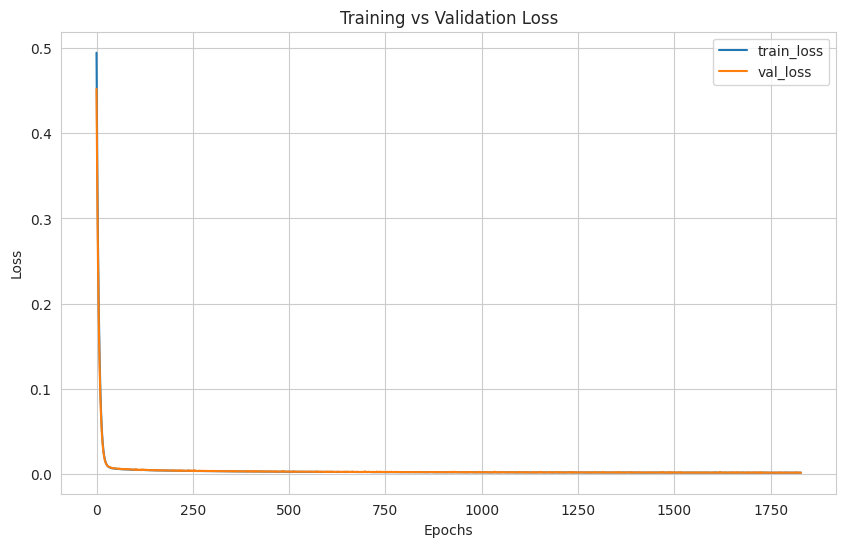

In [44]:
# Displaying training loss vs. validation loss
plot_loss(history)

# Summary

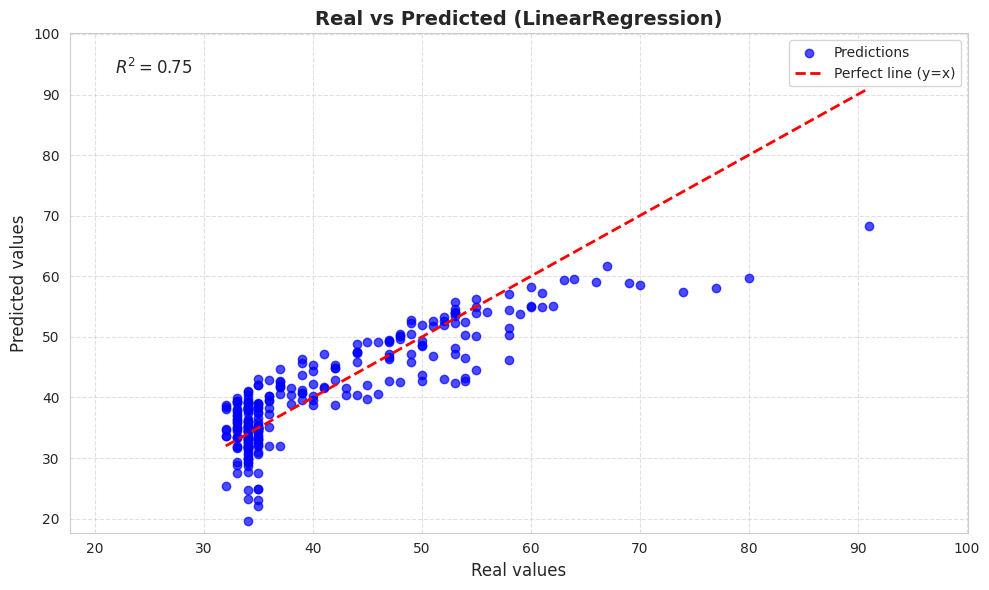

Model: LinearRegression
MSE: 25.382
R2: 0.754


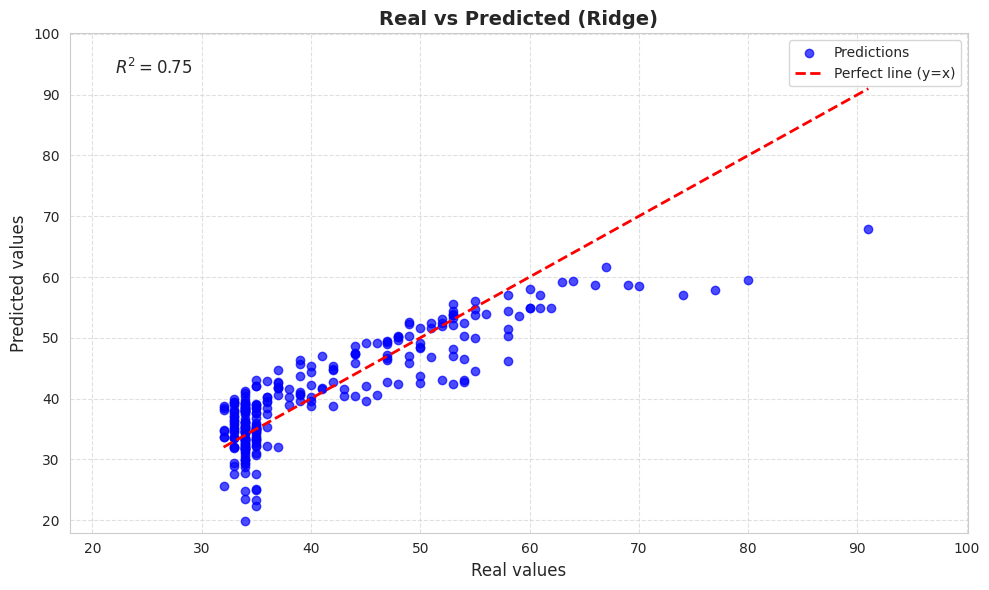

Model: Ridge
MSE: 25.435
R2: 0.754
model__alpha: 10.0


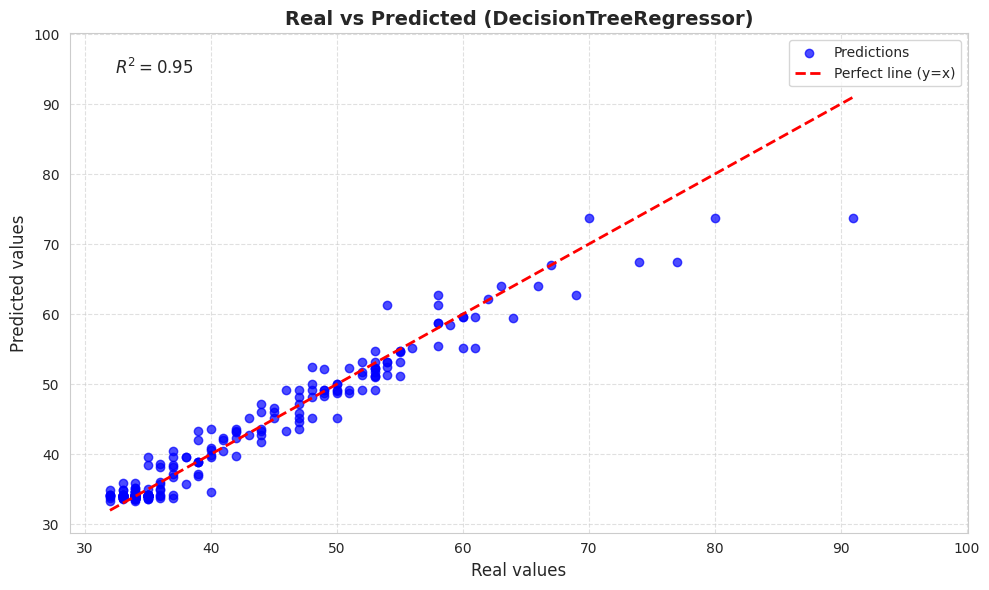

Model: DecisionTreeRegressor
MSE: 4.678
R2: 0.955
model__min_samples_split: 10
model__min_samples_leaf: 5
model__max_depth: 10


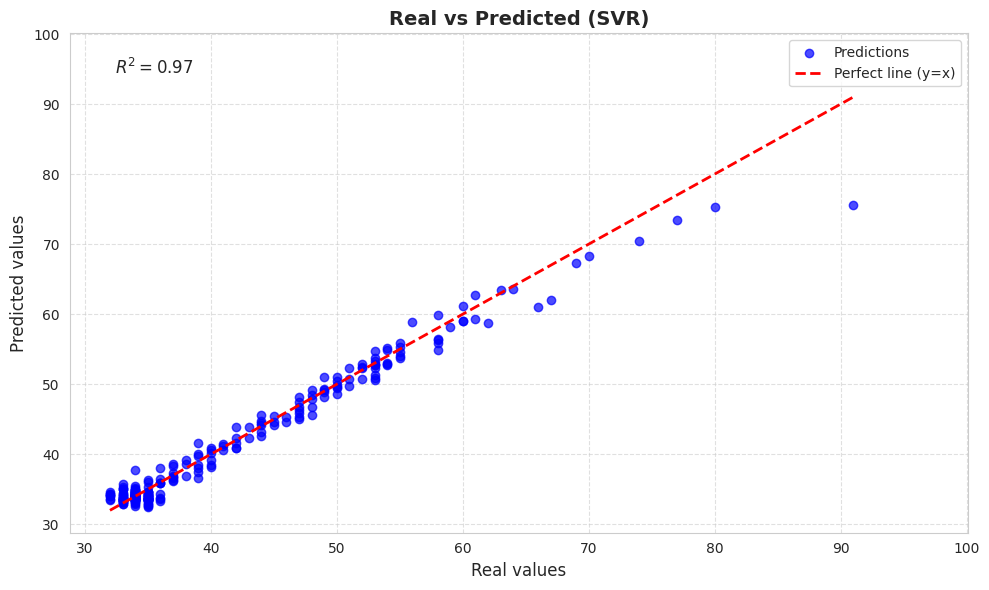

Model: SVR
MSE: 2.628
R2: 0.975
model__kernel: rbf
model__epsilon: 0.5
model__C: 100


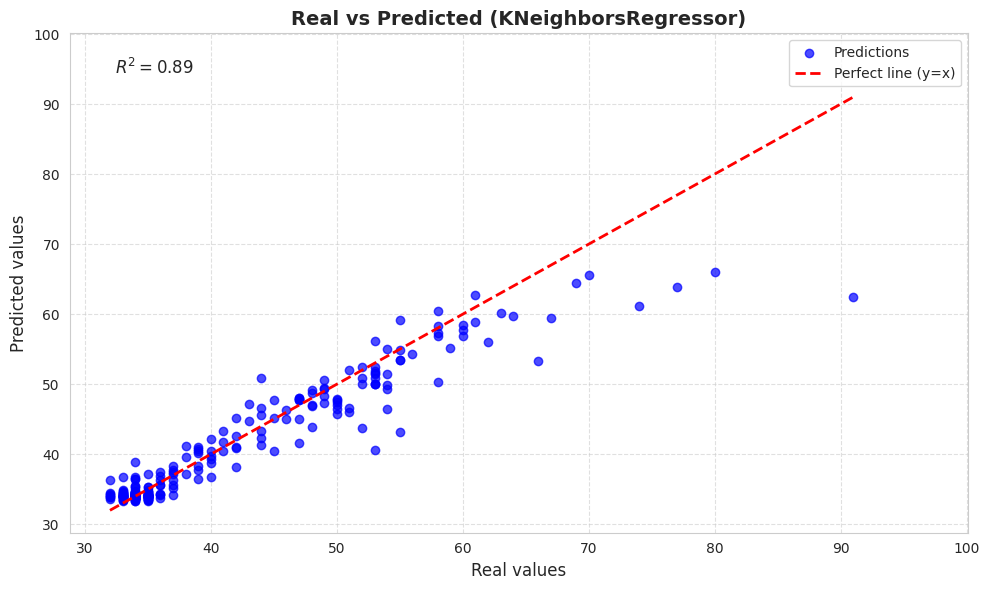

Model: KNeighborsRegressor
MSE: 10.849
R2: 0.895
model__weights: distance
model__n_neighbors: 7


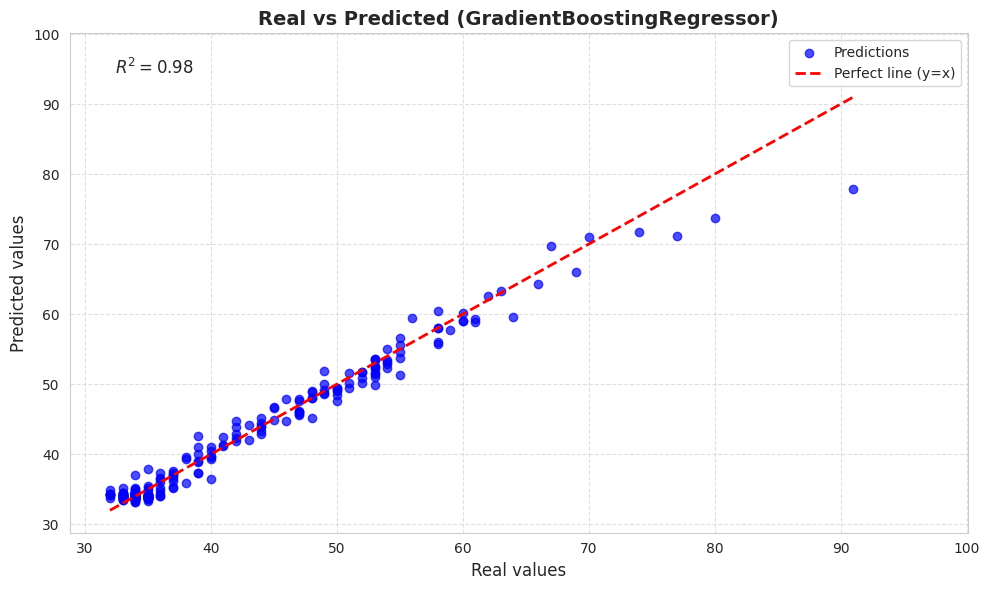

Model: GradientBoostingRegressor
MSE: 2.465
R2: 0.976
model__n_estimators: 100
model__max_depth: 5
model__learning_rate: 0.1


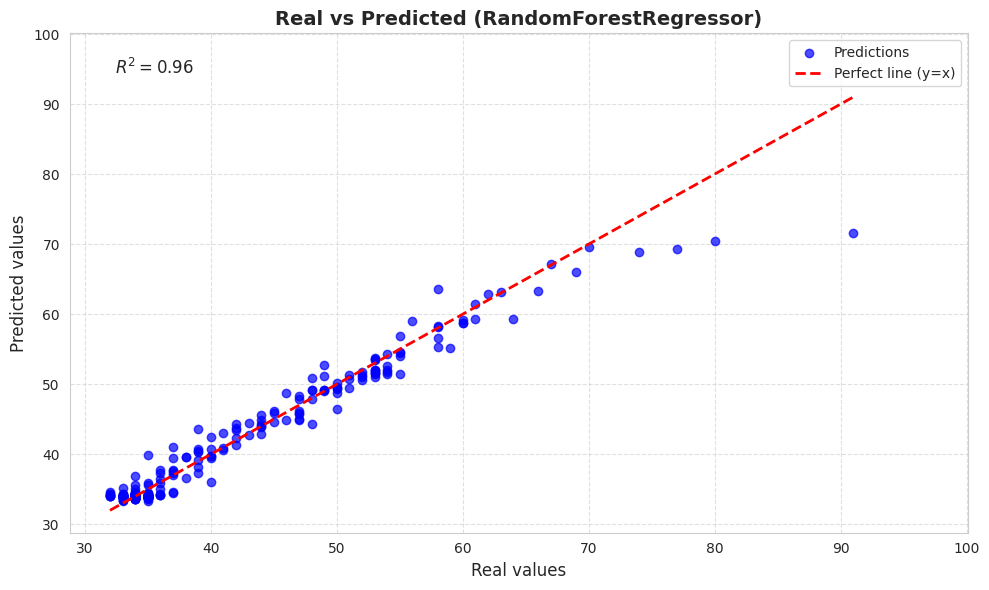

Model: RandomForestRegressor
MSE: 4.040
R2: 0.961
model__n_estimators: 100
model__min_samples_split: 10
model__min_samples_leaf: 1
model__max_features: None
model__max_depth: None
model__bootstrap: True


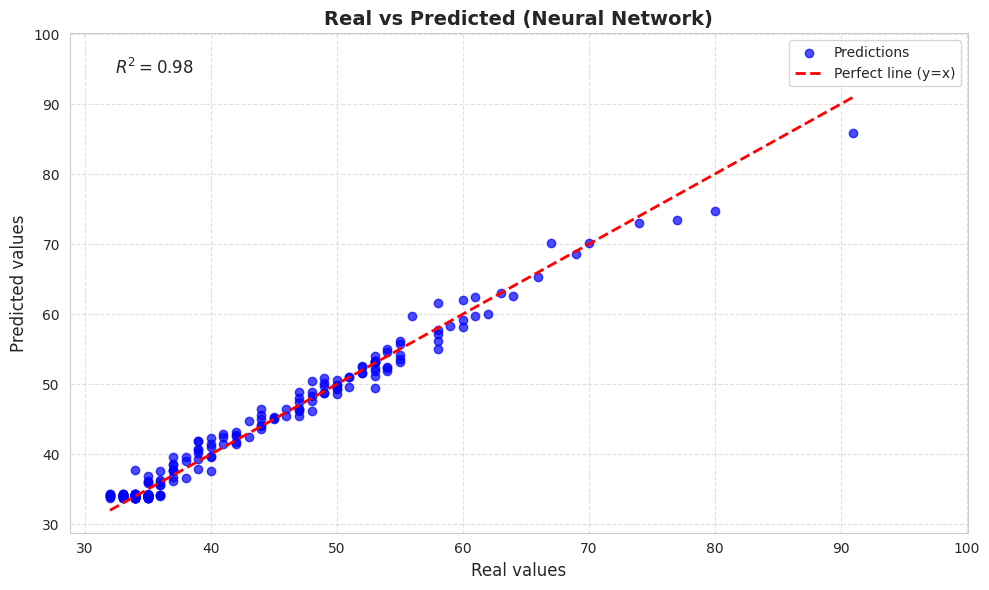

Model: Neural Network
MSE: 1.591
R2: 0.985


In [50]:
for model in model_results:
  # Generates a plot comparing actual values with those predicted by the model
  real_vs_predicted_plot(model['Model'], y_test, model['y_pred'])

  # Displays the model metrics (R², MSE), along with the best parameters.
  print_model_metrics(model['Model'], y_test, model['y_pred'], model['best_params'])

In [46]:
# Converting model_results list to DataFrame
model_results_df = pd.DataFrame(model_results)
model_results_df.sort_values(by='R-squared Score', ascending=False, inplace=True)
model_results_df = model_results_df.reset_index(drop=True)
model_results_df.drop(['y_pred', 'best_params'], axis=1)

,Model,Mean Squared Error,R-squared Score
0,Neural Network,1.591051,0.984590
1,GradientBoostingRegressor,2.465384,0.976121
2,SVR,2.627798,0.974548
3,RandomForestRegressor,4.040361,0.960867
4,DecisionTreeRegressor,4.677552,0.954695
5,KNeighborsRegressor,10.848973,0.894921
6,LinearRegression,25.382241,0.754158
7,Ridge,25.435168,0.753646


<ipython-input-49-28ccd9000a48>:107: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(model_results_df['Model'], fontsize=12)


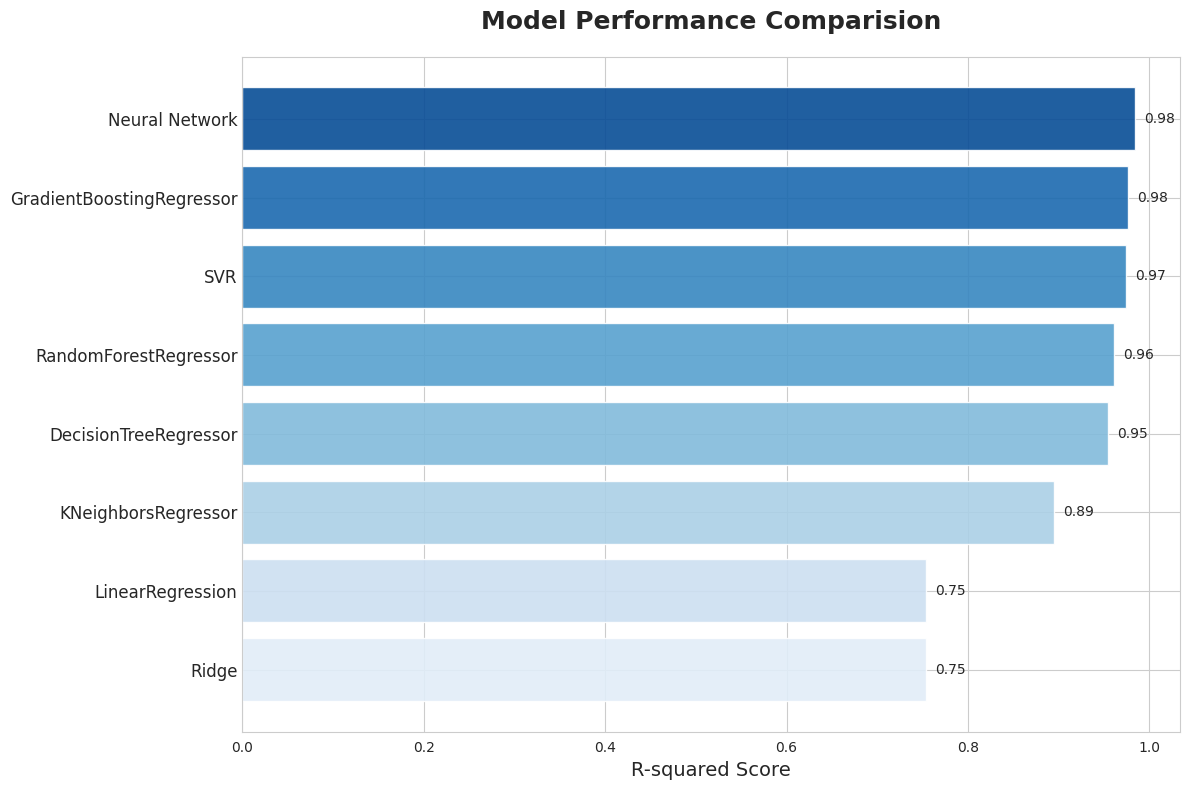

In [51]:
# plotting the performance of different models
plot_model_comparison(model_results_df)

In [48]:
# Displaying real vs predicted values
real_vs_predicted_df = pd.DataFrame({'Real Values': y_test})

for model in model_results:
  real_vs_predicted_df[model['Model']] = model['y_pred'].round(3)

real_vs_predicted_df = real_vs_predicted_df.reset_index(drop=True)
real_vs_predicted_df.head(10)

,Real Values,LinearRegression,Ridge,DecisionTreeRegressor,SVR,KNeighborsRegressor,GradientBoostingRegressor,RandomForestRegressor,Neural Network
0,34.0,24.685,24.822,33.643,34.401,34.100,33.901,33.597,33.866001
1,53.0,48.204,48.105,51.000,50.861,50.036,50.983,51.393,51.242001
2,34.0,34.616,34.714,34.178,33.972,33.870,34.109,34.059,34.095001
3,54.0,43.140,43.068,53.200,52.829,49.294,52.938,51.512,52.327000
4,39.0,45.667,45.703,38.833,36.580,40.971,40.057,40.502,41.866001
5,35.0,23.120,23.334,34.020,33.522,34.095,34.088,34.117,33.729000
6,33.0,29.271,29.380,34.020,33.477,33.554,33.963,33.752,33.849998
7,34.0,38.400,38.430,34.600,34.725,36.530,35.224,35.089,34.346001
8,74.0,57.349,57.100,67.429,70.439,61.150,71.802,68.907,73.028999
9,36.0,39.578,39.665,35.000,35.944,36.388,35.244,35.111,35.671001
